# Import Useful Modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import gmtime, strftime
import time
import datetime
from collections import Counter
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Embedder
from gensim.models import FastText

# Classifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.grid_search import GridSearchCV as GS
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures as Poly

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD

D:\Program\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\Program\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Program\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Program\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversi

In [2]:
#Determine Model's File Location

version = "version_6"

# ---------------------------------------------------------------------------------------------------------------

# Import Model

In [3]:
from preprocessing_pipeline import preprocessing

In [4]:
with open("model/{}/word_embedder.pickle".format(version), "rb") as file:
    word_embedder = pickle.load(file)

## Check

#### Preprocessing

In [5]:
preprocessor=preprocessing(word_embedder.vector_size,word_embedder)
preprocessor

#### Word Embedding

In [6]:
word_embedder

# ---------------------------------------------------------------------------------------------------------------

# Read Data To Pandas Dataframe

In [7]:
large_data_for_classification=pd.read_csv("data/query.csv",header=None)
large_data_for_classification.dropna(axis=0,inplace=True)

In [16]:
large_data_for_classification.head()

,0,1,2
0,hunting,gear+camping,327
1,koleksi,Lightstick+EXO,63
2,kartu-perdana,vivo+v7,183
3,aksesoris-mobil,subwoofer+kolong+aktif,389
4,anak-perempuan,Hotpants+anak,1366


### Preprocess Data

In [15]:
raw_category_mapper=pd.read_csv("raw_leaf.csv",index_col=0)

category_mapper={}
for i in raw_category_mapper.index:
    category_mapper[raw_category_mapper["l2"][i]]=raw_category_mapper["l1"][i]

In [17]:
new_category=[category_mapper[value] for value in large_data_for_classification[0]]
large_data_for_classification[0]=new_category

In [18]:
large_data_for_classification.head()

,0,1,2
0,olahraga,gear+camping,327
1,hobi,Lightstick+EXO,63
2,hp,vivo+v7,183
3,mobil,subwoofer+kolong+aktif,389
4,fashion_anak,Hotpants+anak,1366


In [ ]:
#preprocess product title to 100-dimensional vector
#and preprocess category name to integer label
large_embedded_data, large_label_encoder = preprocessor.preprocess_data(
    large_data_for_classification[1],
    large_data_for_classification[0],
)

REMOVING PUNCTUATIONS


100%|███████████████████████████████████████████████████████████████████████| 2440682/2440682 [00:30<00:00, 79685.38it/s]


CONVERTING SENTENCE TO VECTOR


 99%|██████████████████████████████████████████████████████████████████████▎| 2418290/2440682 [01:51<00:01, 21698.35it/s]

In [18]:
large_embedded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Labels
0,0.275295,-0.438877,0.347446,0.420617,-0.655826,-0.893736,-0.268864,0.091967,0.253759,-0.407018,...,0.060328,0.121378,-0.236838,1.079665,-0.457356,-0.169778,-0.031531,-0.533224,-0.596936,10
1,0.225148,1.786125,0.616444,-0.040366,-0.316455,0.551794,-0.654612,-0.795263,1.905773,0.121287,...,-2.228765,-0.147218,0.039434,-0.156134,-0.311683,0.178662,0.349768,-0.696280,0.755887,6
2,0.227633,-0.858571,-0.520574,0.164235,-2.518956,-0.054563,1.125197,1.010731,0.801415,1.163370,...,-3.043469,2.140666,-2.564406,2.357174,1.715434,-0.115448,-2.115783,-2.267262,-1.784940,12
3,1.103322,-0.371176,1.602983,0.019839,0.338218,-2.489933,-1.299406,1.602620,1.629507,1.238133,...,-1.477074,-2.458070,-1.160693,1.680575,0.541392,1.173590,-2.529253,-1.546401,1.537661,3
4,-0.096464,-0.166233,0.577785,0.399365,-0.718592,-0.854424,0.374337,-0.318422,-0.018439,0.245501,...,-0.487409,0.230962,-0.333771,0.158394,0.055914,0.179707,0.396101,-0.485040,-0.054236,10


In [19]:
large_embedded_data["sum"]=large_embedded_data.drop(["Labels"],axis=1).sum(axis=1)

In [20]:
large_embedded_data=large_embedded_data.loc[large_embedded_data["sum"]!=0].drop("sum",axis=1)

In [21]:
large_embedded_data.shape

(392527, 101)

In [22]:
large_label_encoder

LabelEncoder()

# ---------------------------------------------------------------------------------------------------------------

### Build Neural Network

In [24]:
data=large_embedded_data.copy()
sampled_embedded_data=data.sample(n=len(data))

In [25]:
nn_X_train,nn_X_test,nn_y_train,nn_y_test=train_test_split(sampled_embedded_data.drop("Labels",axis=1),to_categorical(sampled_embedded_data["Labels"]),test_size=0.02)

In [26]:
def accuracy(predicted,truth):
    result=[int(value) for value in np.array(predicted)==np.array(truth)]
    return sum(result)/len(result)

In [29]:
model = Sequential()
model.add(Dense(2000, input_shape=(100,), activation='relu'))
model.add(Dense(1500, activation='relu'))
model.add(Dense(1000, activation='relu'))
# model.add(Dense(750, activation='relu'))
model.add(Dense(20, activation='softmax'))


model.compile(optimizer="Adagrad", loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
history = model.fit(nn_X_train, nn_y_train,initial_epoch=11, epochs=12, batch_size=100, validation_data=(nn_X_test,nn_y_test), shuffle=True)

Train on 384676 samples, validate on 7851 samples
Epoch 12/12
384676/384676 [==============================] - 452s 1ms/step - loss: 0.3092 - acc: 0.8940 - val_loss: 0.5687 - val_acc: 0.8491


In [40]:
model.save("model_85val_90sing_20classes.h5")

# ---------------------------------------------------------------------------------------------------------------

In [56]:
nn_y_truth=[np.argmax(value) for value in nn_y_test]
nn_y_pred=[np.argmax(value) for value in model.predict(nn_X_test)]
print("Validation Accuracy : {}".format(accuracy(nn_y_pred,nn_y_truth)))

Validation Accuracy : 0.8589988536492167


In [54]:
nn_y_truth=[np.argmax(value) for value in nn_y_train]
nn_y_pred=[np.argmax(value) for value in model.predict(nn_X_train)]
print("Train Accuracy : {}".format(accuracy(nn_y_pred,nn_y_truth)))

Train Accuracy : 0.901197371294284


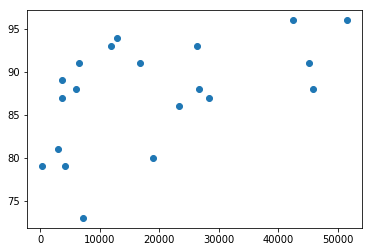

In [39]:
support=[18901,4163,45911,23344,3616,51494,45244,7200,11880,5949,26305,16711,42462,26672,6538,3717,3031,28350,12843,345]
fscore=[80,79,88,86,89,96,91,73,93,88,93,91,96,88,91,87,81,87,94,79]
plt.scatter(support,fscore)
plt.show()

In [57]:
print(classification_report(nn_y_truth,nn_y_pred))

             precision    recall  f1-score   support

          0       0.75      0.68      0.71       376
          1       0.78      0.75      0.77        83
          2       0.81      0.91      0.86       946
          3       0.88      0.79      0.83       481
          4       0.82      0.82      0.82        72
          5       0.95      0.94      0.95      1082
          6       0.85      0.86      0.85       912
          7       0.61      0.59      0.60       137
          8       0.88      0.92      0.90       238
          9       0.75      0.69      0.72       109
         10       0.89      0.89      0.89       550
         11       0.86      0.85      0.86       355
         12       0.94      0.95      0.94       884
         13       0.87      0.80      0.83       527
         14       0.79      0.86      0.82       111
         15       0.86      0.74      0.80        85
         16       0.69      0.66      0.67        67
         17       0.77      0.80      0.79   

In [38]:
classification_report(nn_y_truth,nn_y_pred)["support"]

TypeError: string indices must be integers

In [41]:
data=large_embedded_data.copy()
sampled_embedded_data=data.sample(n=len(data))

In [42]:
nn_X_train,nn_X_test,nn_y_train,nn_y_test=train_test_split(sampled_embedded_data.drop("Labels",axis=1),to_categorical(sampled_embedded_data["Labels"]),test_size=0.02)

In [43]:
def accuracy(predicted,truth):
    result=[int(value) for value in np.array(predicted)==np.array(truth)]
    return sum(result)/len(result)

In [48]:
model = Sequential()
model.add(Dense(2500, input_shape=(100,), activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(1500, activation='relu'))
model.add(Dense(20, activation='softmax'))


model.compile(optimizer="Adagrad", loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
history = model.fit(nn_X_train, nn_y_train,epochs=5, batch_size=100, validation_data=(nn_X_test,nn_y_test), shuffle=True)

Train on 384676 samples, validate on 7851 samples
Epoch 1/5
384676/384676 [==============================] - 759s 2ms/step - loss: 0.8648 - acc: 0.7660 - val_loss: 0.6498 - val_acc: 0.8100
Epoch 2/5
384676/384676 [==============================] - 767s 2ms/step - loss: 0.5942 - acc: 0.8240 - val_loss: 0.5725 - val_acc: 0.8333
Epoch 3/5
384676/384676 [==============================] - 765s 2ms/step - loss: 0.5006 - acc: 0.8488 - val_loss: 0.5384 - val_acc: 0.8429
Epoch 4/5
384676/384676 [==============================] - 767s 2ms/step - loss: 0.4376 - acc: 0.8648 - val_loss: 0.5270 - val_acc: 0.8475
Epoch 5/5
384676/384676 [==============================] - 777s 2ms/step - loss: 0.3929 - acc: 0.8752 - val_loss: 0.5235 - val_acc: 0.8517


In [51]:
history = model.fit(nn_X_train, nn_y_train,initial_epoch=5, epochs=7, batch_size=100, validation_data=(nn_X_test,nn_y_test), shuffle=True)

Train on 384676 samples, validate on 7851 samples
Epoch 6/7
384676/384676 [==============================] - 772s 2ms/step - loss: 0.3609 - acc: 0.8823 - val_loss: 0.5217 - val_acc: 0.8524
Epoch 7/7
384676/384676 [==============================] - 801s 2ms/step - loss: 0.3367 - acc: 0.8874 - val_loss: 0.5164 - val_acc: 0.8559


In [58]:
history = model.fit(nn_X_train, nn_y_train,initial_epoch=8, epochs=10, batch_size=100, validation_data=(nn_X_test,nn_y_test), shuffle=True)

Train on 384676 samples, validate on 7851 samples
Epoch 9/10
384676/384676 [==============================] - 796s 2ms/step - loss: 0.3046 - acc: 0.8937 - val_loss: 0.5260 - val_acc: 0.8596
Epoch 10/10
384676/384676 [==============================] - 796s 2ms/step - loss: 0.2937 - acc: 0.8961 - val_loss: 0.5281 - val_acc: 0.8575


In [59]:
model.save("model_90sing_86val_20classes.h5")

In [60]:
history = model.fit(nn_X_train, nn_y_train,initial_epoch=10, epochs=13, batch_size=100, validation_data=(nn_X_test,nn_y_test), shuffle=True)

Train on 384676 samples, validate on 7851 samples
Epoch 11/13
384676/384676 [==============================] - 831s 2ms/step - loss: 0.2855 - acc: 0.8974 - val_loss: 0.5296 - val_acc: 0.8607
Epoch 12/13
384676/384676 [==============================] - 827s 2ms/step - loss: 0.2782 - acc: 0.8987 - val_loss: 0.5295 - val_acc: 0.8612
Epoch 13/13
  1000/384676 [..............................] - ETA: 12:53 - loss: 0.2386 - acc: 0.90

KeyboardInterrupt: 

In [61]:
model.save("model_90sing_86val_20classes.h5")

In [22]:
globals()

{'Activation': keras.layers.core.Activation,
 'Counter': collections.Counter,
 'Dense': keras.layers.core.Dense,
 'Dropout': keras.layers.core.Dropout,
 'FastText': gensim.models.fasttext.FastText,
 'GBC': sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 'GS': sklearn.grid_search.GridSearchCV,
 'In': ['',
  'import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom time import gmtime, strftime\nimport time\nimport datetime\nfrom collections import Counter\nimport pickle\n\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import classification_report\n\n# Preprocessing\nfrom sklearn.preprocessing import LabelEncoder, OneHotEncoder\n\n# Embedder\nfrom gensim.models import FastText\n\n# Classifier\nfrom sklearn.svm import SVC\nfrom sklearn.ensemble import GradientBoostingClassifier as GBC\nfrom sklearn.linear_model import LogisticRegression as LR\nfrom sklearn.ensemble import RandomForestClassifier as RFC\nfrom sklearn.grid_sea